In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib

In [2]:
df = pd.read_csv('D:\\Users\\flammmes\\Downloads\\Book1.csv')
df['d']=df['d'].str.replace(',','')
df['Rsob']=df['Rsob'].str.replace(',','')
dfn = pd.read_csv('D:\\Users\\flammmes\\Downloads\\composition.csv')


dd = df.d.astype('float')
df.d = df.d.astype('float')
df['Rsob']= df['Rsob'].astype('float')
df['Rsob']= np.abs(df['Rsob'])
x = df.iloc[:,1]/df.iloc[:,8]
mu = 1000*(df.iloc[:,3]*x*x+df.iloc[:,4]*x+df.iloc[:,5])/(df.iloc[:,6]*x+1)
df.insert(9,'μob',mu)
df.insert(12,'Tr',dfn.Tres)

df = df[df['μob']<=50] #50,338


In [3]:
##strat1
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')
#df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)




##strat2
#df.dropna(inplace=True)


##strat3
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=5, weights="uniform")
#df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



In [4]:
##strat4
#df.Rsob[df.Rsob==0] = np.nan
df.μob = 1/np.power(df.μob,1/1.5)
my_new = pd.DataFrame({
    'Pb':df.Pb,'μob':df.μob ,'Rs':df.Rsob
})
bb = my_new[my_new['Rs'].isnull().values]
aa = my_new[my_new['Rs'].notnull().values]
dat = aa.iloc[:,0:2].to_numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dat =scaler.fit_transform(dat)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(dat, aa.Rs)

dat2 =bb.iloc[:,0:2].to_numpy()
dat2 =scaler.transform(dat2)
df['Rsob'][df['Rsob'].isnull().values] = forest_reg.predict(dat2)
df.μob = 1/np.power(df.μob,1.5)

df.μob = np.log(df.μob)
my_new = pd.DataFrame({
    'μob':df.μob, 'STO':df.STO
})
bb = my_new[my_new['STO'].isnull().values]
aa = my_new[my_new['STO'].notnull().values]
dat = aa.μob.to_numpy().reshape(-1,1)
scaler2 = StandardScaler()
dat =scaler2.fit_transform(dat)
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(dat, aa.STO)
dat2 = bb.μob.to_numpy().reshape(-1,1)
dat2 =scaler2.transform(dat2)
df['STO'][df['STO'].isnull().values] = lin_reg.predict(dat2)
df.μob = np.exp(df.μob)


my_new = pd.DataFrame({
    'Pb':df.Pb,'Pmax':df.Pmax ,'Rs':df.Rsob,'Tr':df.Tr
})
bb = my_new[my_new['Tr'].isnull().values]
aa = my_new[my_new['Tr'].notnull().values]
dat = aa.iloc[:,0:3].to_numpy()
scaler3 = StandardScaler()
dat =scaler3.fit_transform(dat)
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(dat, aa.Tr)
dat2 =bb.iloc[:,0:3].to_numpy()
dat2 =scaler3.transform(dat2)
df['Tr'][df['Tr'].isnull().values] = forest_reg.predict(dat2)

C:\Users\flammmes\AppData\Local\Temp/ipykernel_9464/794019730.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rsob'][df['Rsob'].isnull().values] = forest_reg.predict(dat2)
C:\Users\flammmes\AppData\Local\Temp/ipykernel_9464/794019730.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STO'][df['STO'].isnull().values] = lin_reg.predict(dat2)
C:\Users\flammmes\AppData\Local\Temp/ipykernel_9464/794019730.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [5]:
df["μob_cat"] = pd.cut(df["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [6]:
df["μob_cat"].value_counts()

1    485
2     86
Name: μob_cat, dtype: int64

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=13)
for train_index, test_index in split.split(df, df["μob_cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)
   

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
df1 = strat_train_set.copy()
df2 = strat_test_set.copy()

In [10]:
df1["μob_cat"] = pd.cut(df1["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=13)
for ti, tei in split.split(df1, df1["μob_cat"]):
    strat_tr_set = df1.iloc[ti]
    strat_val_set = df1.iloc[tei]
    

In [12]:
for set_ in (strat_tr_set, strat_val_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
df_train = strat_tr_set.copy()
df_val = strat_val_set.copy()


In [14]:
def gen_func(a):
    
    dflist = []
    for i in range(len(a)):
        
        instance = a.iloc[i,:].to_numpy(dtype=float)
        P_i=np.linspace(instance[1],instance[2],num=20)
        x_i = P_i/instance[8]
        mu_i = 1000*(instance[3]*x_i*x_i+instance[4]*x_i+instance[5])/(instance[6]*x_i+1)
        correlations_select = pd.DataFrame({'P':P_i,'μ':mu_i,'Rsob':instance[10],'API':instance[11],'Tr':instance[12]})
        pressure_bubble_point = correlations_select.iloc[0,0]*np.linspace(1,1,20)
        visc_bubble_point = correlations_select.iloc[0,1]*np.linspace(1,1,20)
        correlations_select.insert(0,"Pb",pressure_bubble_point)
        correlations_select.insert(2,'μob',visc_bubble_point)
        dflist.append(correlations_select)
        
    
    totaldf = pd.concat(dflist)
    totaldf.Pb = totaldf.Pb*145.038
    totaldf.P = totaldf.P*145.038
    totaldf.insert(2,'ΔP', totaldf.P-totaldf.Pb)
    
    totaldf.API = 141.5*1000/totaldf.API -131.5
    totaldf.Rsob = totaldf.Rsob*5.614583333333333
    #totaldf = totaldf[totaldf.μ != totaldf.μob]
    #totaldf.drop('P',axis=1,inplace=True)
    return totaldf

In [15]:
test_data = gen_func(df2)
train_data = gen_func(df_train)
val_data = gen_func(df_val)

#y = test_data[test_data.ΔP==0]
#x =  val_data[val_data.ΔP==0]
#train_data = pd.concat([train_data,y,x])
all_data = gen_func(df)

In [16]:
np.sqrt(all_data.ΔP.mean())

39.32676969185716

In [17]:
for a in [test_data,train_data,val_data,all_data]:
    a.μ = np.sqrt(np.log(a.μ/a.μob+0.0012))
    a.ΔP = np.power(a.ΔP,0.5)
    #a.ΔP = np.log(a.ΔP+1)
    #a.insert(0,'x1',a.ΔP*np.power(a.P/a.Pb,0.2))
    a.μob = a.ΔP*np.power(a.μob,0.07)

    #a.insert(4,'logμob',a.μob*np.log(a.μob))
    a.Pb = a.ΔP/np.log(a.Pb+400)
    a.P = a.ΔP*np.power(a.P,-0.15)
    a.API = a.ΔP/np.power(a.API,0.3)
    a.Rsob = a.ΔP/np.log(a.Rsob+150)
    #a.drop('μob',axis=1,inplace=True)
    a.Tr = a.ΔP*np.power(a.Tr,-1.)

In [18]:
corr_matrix = all_data.corr()
corr_matrix["μ"].sort_values(ascending=False)

μ       1.000000
μob     0.893792
API     0.891319
Rsob    0.887188
Pb      0.881542
Tr      0.879291
P       0.877724
ΔP      0.868429
Name: μ, dtype: float64

(array([  1., 574.,  11.,  49., 144., 195., 273., 313., 351., 372., 414.,
        435., 483., 508., 518., 524., 535., 539., 506., 490., 491., 444.,
        430., 406., 337., 300., 266., 221., 213., 188., 153., 130., 115.,
         94.,  77.,  58.,  53.,  41.,  34.,  27.,  26.,  21.,  12.,  12.,
         11.,  11.,   3.,   6.,   2.,   3.]),
 array([0.00188016, 0.02084077, 0.03980137, 0.05876198, 0.07772259,
        0.0966832 , 0.1156438 , 0.13460441, 0.15356502, 0.17252563,
        0.19148623, 0.21044684, 0.22940745, 0.24836806, 0.26732866,
        0.28628927, 0.30524988, 0.32421048, 0.34317109, 0.3621317 ,
        0.38109231, 0.40005291, 0.41901352, 0.43797413, 0.45693474,
        0.47589534, 0.49485595, 0.51381656, 0.53277716, 0.55173777,
        0.57069838, 0.58965899, 0.60861959, 0.6275802 , 0.64654081,
        0.66550142, 0.68446202, 0.70342263, 0.72238324, 0.74134384,
        0.76030445, 0.77926506, 0.79822567, 0.81718627, 0.83614688,
        0.85510749, 0.8740681 , 0.8930287 , 0.

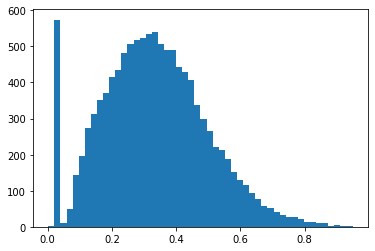

In [19]:
plt.hist(all_data.μ,bins=50)

array([[<AxesSubplot:title={'center':'Pb'}>,
        <AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'ΔP'}>],
       [<AxesSubplot:title={'center':'μob'}>,
        <AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'Rsob'}>],
       [<AxesSubplot:title={'center':'API'}>,
        <AxesSubplot:title={'center':'Tr'}>, <AxesSubplot:>]],
      dtype=object)

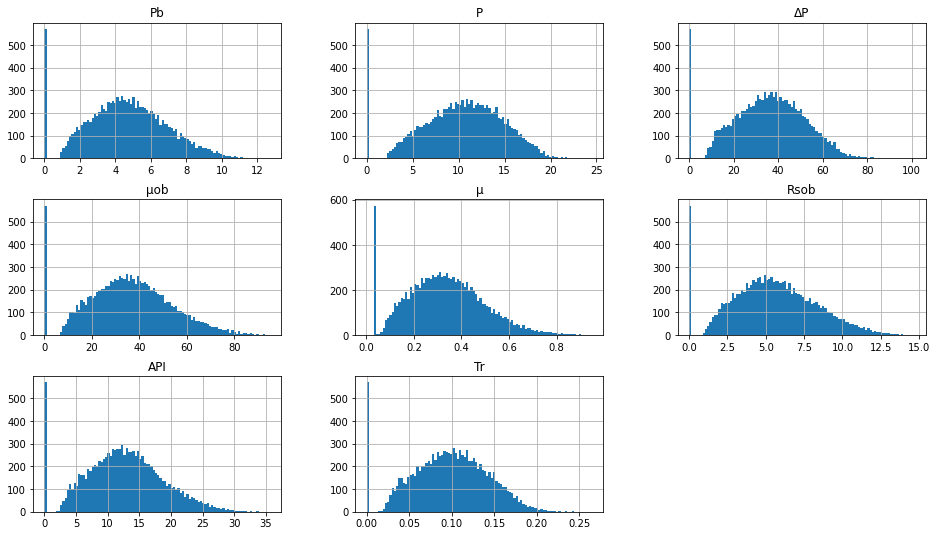

In [20]:
all_data.hist(bins=100,figsize=(16,9))


In [21]:
all_data

,Pb,P,ΔP,μob,μ,Rsob,API,Tr
0,0.000000,0.000000,0.000000,0.000000,0.034631,0.000000,0.000000,0.000000
1,1.910324,4.752203,14.123531,15.004605,0.116077,2.353238,4.986188,0.038679
2,2.701606,6.589802,19.973689,21.219716,0.179595,3.327982,7.051535,0.054700
3,3.308778,7.931781,24.462673,25.988738,0.228066,4.075929,8.636332,0.066993
4,3.820648,9.017313,28.247061,30.009210,0.268089,4.706477,9.972377,0.077357
...,...,...,...,...,...,...,...,...
15,6.137712,13.756415,52.226794,50.263283,0.290937,7.132412,18.064873,0.134361
16,6.339002,14.155137,53.939601,51.911695,0.302167,7.366323,18.657321,0.138767
17,6.534094,14.538234,55.599669,53.509351,0.313081,7.593032,19.231526,0.143038
18,6.723527,14.907105,57.211587,55.060668,0.323699,7.813166,19.789077,0.147185


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

X_train = train_data.drop(["μ"], axis=1) 
y_train = train_data["μ"].copy()
X_val = val_data.drop(["μ"], axis=1) 
y_val = val_data["μ"].copy()
X_test = test_data.drop(["μ"], axis=1) # drop labels for training set
y_test = test_data["μ"].copy()


In [23]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.fit_transform(X_val)
X_test_poly = poly_features.fit_transform(X_test)
poly_scaler = StandardScaler()
X_train_poly = poly_scaler.fit_transform(X_train_poly)
X_val_poly = poly_scaler.transform(X_val_poly)
X_test_poly = poly_scaler.transform(X_test_poly)


In [24]:
X_train_poly

array([[-2.03772153, -2.27848118, -2.14789758, ..., -1.16643581,
        -1.23504049, -1.2703793 ],
       [-1.08886032, -1.10686692, -1.14276735, ..., -0.99849722,
        -1.03254514, -1.03557666],
       [-0.69582914, -0.65223951, -0.72642878, ..., -0.83055863,
        -0.83004979, -0.80077401],
       ...,
       [ 0.87852561,  0.97764685,  1.14251862, ...,  0.57219397,
         0.6780285 ,  0.75393303],
       [ 0.96307202,  1.05816253,  1.23791276, ...,  0.67446631,
         0.79056197,  0.87301023],
       [ 1.04530076,  1.13577053,  1.33069186, ...,  0.77673865,
         0.90309544,  0.99208742]])

In [25]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val= scaler.transform(X_val)
X_test= scaler.transform(X_test)


In [26]:
X_features_full = [X_train,X_val,X_test]
X_features_poly_full = [X_train_poly,X_val_poly,X_test_poly]
y_labels_full = [y_train,y_val,y_test]


In [27]:
%store X_features_full
%store X_features_poly_full
%store y_labels_full


Stored 'X_features_full' (list)
Stored 'X_features_poly_full' (list)
Stored 'y_labels_full' (list)


In [28]:
totaldf_full = gen_func(df2)
%store totaldf_full
totaldf_full
all_data_full = gen_func(df)
%store all_data_full

Stored 'totaldf_full' (DataFrame)
Stored 'all_data_full' (DataFrame)


In [29]:
X_features_full[0]

array([[-2.03772153, -2.27848118, -2.14789758, ..., -1.99367471,
        -2.04531475, -2.14149021],
       [-1.08886032, -1.10686692, -1.14276735, ..., -1.12875036,
        -1.18144449, -1.1253948 ],
       [-0.69582914, -0.65223951, -0.72642878, ..., -0.77048697,
        -0.82361772, -0.7045143 ],
       ...,
       [ 0.87852561,  0.97764685,  1.14251862, ...,  0.24934596,
         0.73425021,  0.84198035],
       [ 0.96307202,  1.05816253,  1.23791276, ...,  0.31437452,
         0.814834  ,  0.92847567],
       [ 1.04530076,  1.13577053,  1.33069186, ...,  0.37762046,
         0.89320875,  1.0125999 ]])

In [30]:
corr_matrix = all_data.corr()
corr_matrix["μ"].sort_values(ascending=False)

μ       1.000000
μob     0.893792
API     0.891319
Rsob    0.887188
Pb      0.881542
Tr      0.879291
P       0.877724
ΔP      0.868429
Name: μ, dtype: float64

In [31]:
#from pandas.plotting import scatter_matrix

#attributes = ["Pb",'Rsob','P','API','ΔP','μ','μob','Tr']
#scatter_matrix(all_data[attributes], figsize=(12, 8))

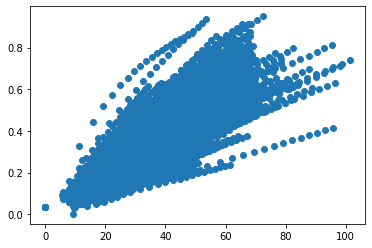

In [32]:
plt.scatter(all_data.ΔP,all_data.μ)


In [33]:
pp = all_data.loc[all_data.μ<=0.5 ]
pp[pp.ΔP>100]

,Pb,P,ΔP,μob,μ,Rsob,API,Tr


In [34]:
pp = all_data.loc[all_data.μ<=0.5 ]
pp[pp.ΔP<600]

,Pb,P,ΔP,μob,μ,Rsob,API,Tr
0,0.000000,0.000000,0.000000,0.000000,0.034631,0.000000,0.000000,0.000000
1,1.910324,4.752203,14.123531,15.004605,0.116077,2.353238,4.986188,0.038679
2,2.701606,6.589802,19.973689,21.219716,0.179595,3.327982,7.051535,0.054700
3,3.308778,7.931781,24.462673,25.988738,0.228066,4.075929,8.636332,0.066993
4,3.820648,9.017313,28.247061,30.009210,0.268089,4.706477,9.972377,0.077357
...,...,...,...,...,...,...,...,...
15,6.137712,13.756415,52.226794,50.263283,0.290937,7.132412,18.064873,0.134361
16,6.339002,14.155137,53.939601,51.911695,0.302167,7.366323,18.657321,0.138767
17,6.534094,14.538234,55.599669,53.509351,0.313081,7.593032,19.231526,0.143038
18,6.723527,14.907105,57.211587,55.060668,0.323699,7.813166,19.789077,0.147185


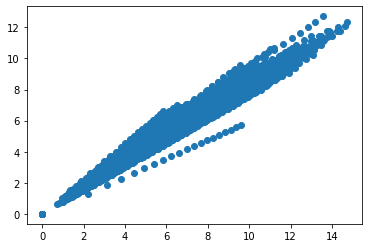

In [35]:
plt.scatter(all_data.Rsob,all_data.Pb)


In [36]:
test_data

,Pb,P,ΔP,μob,μ,Rsob,API,Tr
0,0.000000,0.000000,0.000000,0.000000,0.034631,0.000000,0.000000,0.000000
1,2.457727,6.269954,15.861252,18.395401,0.187439,2.940324,5.873268,0.048057
2,3.475751,8.329711,22.431198,26.015026,0.264952,4.158247,8.306056,0.067963
3,4.256908,9.762702,27.472495,31.861769,0.325613,5.092791,10.172799,0.083237
4,4.915454,10.896450,31.722505,36.790802,0.377229,5.880649,11.746537,0.096114
...,...,...,...,...,...,...,...,...
15,5.366468,12.201498,44.964846,40.010577,0.517118,6.003123,15.240554,0.114048
16,5.542464,12.559562,46.439493,41.322746,0.531937,6.199999,15.740377,0.117789
17,5.713041,12.903800,47.868734,42.594511,0.546142,6.390812,16.224809,0.121414
18,5.878671,13.235441,49.256521,43.829391,0.559787,6.576092,16.695191,0.124934


In [37]:
scaler.mean_

array([ 4.6257766 , 10.25322628, 35.41671226, 35.76609448,  5.46596891,
       12.55058804,  0.09633365])

In [38]:
scaler.var_

array([5.15323138e+00, 2.02502408e+01, 2.71887567e+02, 3.11359239e+02,
       7.51667400e+00, 3.76537164e+01, 2.02359600e-03])